# **Insper - Projeto de Eletromagnetismo e Ondulatória - 2022.2** #

Jerônimo Afrange, Matheus Barros, Pedro Altobelli, Thiago Kawahara

## Etapa 1.1

### > Diagrama do modelo eletrodinâmico do circuito WPT

<img src="diagrama.jpeg" alt="Diagrama do circuito"/>

In [1]:
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt

### > Constantes

In [2]:
# indutâncias das bobinas (Henries)
INDUTANCIA_PRIMARIA   = 138.6e-3
INDUTANCIA_SECUNDARIA = 144.3e-3

# capacitâncias dos capacitores (Farads)
CAPACITANCIA_PRIMARIA   = 0.1e-6
CAPACITANCIA_SECUNDARIA = 0.1e-6

# resistências das bobinas e da carga (Ohms)
RESISTENCIA_PRIMARIA   = 0.817
RESISTENCIA_SECUNDARIA = 0.875
RESISTENCIA_CARGA      = 100

### > Definição de funções úteis

In [3]:
def calc_impedancia_capacitiva(capacitancia, frequencia_angular):
    return -1j * 1 / (capacitancia * frequencia_angular)

def calc_impedancia_indutiva(indutancia, frequencia_angular):
    return 1j * indutancia * frequencia_angular

def calc_frequencia_angular(frequencia):
    return 2 * math.pi * frequencia

def calc_indutancia_mutua(indutancia_primaria, indutancia_secundaria, fator_acoplamento):
    return fator_acoplamento * math.sqrt(indutancia_primaria * indutancia_secundaria)

def calc_frequencia(frequencia_angular):
    return frequencia_angular / (2 * math.pi)

def calc_arranjo_paralelo(*impedancias):
    admitancia_acumulada = 0
    for impedancia in impedancias: admitancia_acumulada += 1 / impedancia
    return 1 / admitancia_acumulada

def calc_arranjo_serial(*impedancias):
    impedancia_acumulada = 0
    for impedancia in impedancias: impedancia_acumulada += impedancia
    return impedancia_acumulada

### > Cálculos secundários

In [4]:
# frequência de resonância do transformador
FREQUENCIA_ANGULAR_RESONANTE = (1 / math.sqrt(INDUTANCIA_PRIMARIA * CAPACITANCIA_PRIMARIA)).real
FREQUENCIA_RESONANTE = calc_frequencia(FREQUENCIA_ANGULAR_RESONANTE)

# verbose dos valores
print('Frequência de resonância do transformador:\t%.2f Hz' % round(FREQUENCIA_RESONANTE, 2))


Frequência de resonância do transformador:	1351.88 Hz


## Etapa 1.2

### > Código do modelo numérico

In [5]:
def calcular_transformador(tensao_pico_fonte, frequencia, fator_acoplamento):
    '''
    Calcula diversos valores de diversas grandezas no transformador.
    
    Parâmetros:
    - tensao_pico_fonte (num):   tensão de pico da onda quadrada da fonte
    - frequencia        (num):   frequência da tensão da fonte
    - fator_acoplamento (float): valor de 0 a 1 do fator de acoplamento do transformador
    
    Retorna:
    - resultados (dict(str->num)):
        - "corrente-primaria"  : corrente que percorre a bobina primária
        - "corrente-secundaria": corrente que percorre a bobina secundária
        - "tensao-carga"       : tensão nos terminais da carga
        - "corrente-carga"     : corrente nos terminais da carga
        - "potencia-entrada"   : potência total consumida pelo sistema
        - "potencia-saida"     : potência total disponível na carga
        - "eficiencia"         : eficiência energética do sistema
    
    '''
    
    # define o dicionário de retorno
    resultados = dict()
    
    # calcula a frequência angular da fonte
    frequencia_angular = calc_frequencia_angular(frequencia)
    
    # calcula as impedâncias do transformador
    impedancia_indutor_primaria = calc_impedancia_indutiva(INDUTANCIA_PRIMARIA, frequencia_angular)
    impedancia_indutor_secundaria = calc_impedancia_indutiva(INDUTANCIA_SECUNDARIA, frequencia_angular)
    impedancia_capacitor_primaria = calc_impedancia_capacitiva(CAPACITANCIA_PRIMARIA, frequencia_angular)
    impedancia_capacitor_secundaria = calc_impedancia_capacitiva(CAPACITANCIA_SECUNDARIA, frequencia_angular)
    
    # cálculo da impedância mútua do transformador
    indutancia_mutua = calc_indutancia_mutua(INDUTANCIA_PRIMARIA, INDUTANCIA_SECUNDARIA, fator_acoplamento)
    impedancia_mutua = calc_impedancia_indutiva(indutancia_mutua, frequencia_angular)
    
    # calcula a impedância equivalente da carga e do capacitor da secundária
    impedancia_capacitor_carga = calc_arranjo_paralelo(impedancia_capacitor_secundaria, RESISTENCIA_CARGA)
    
    # calcula valores de tensão relevantes
    tensao_fonte_corrigida = tensao_pico_fonte * 2 / math.pi
    
    # calcula as impedâncias combinadas
    impedancia_primaria = calc_arranjo_serial(RESISTENCIA_PRIMARIA, impedancia_indutor_primaria, impedancia_capacitor_primaria)
    impedancia_secundaria = calc_arranjo_serial(RESISTENCIA_SECUNDARIA, impedancia_indutor_secundaria, impedancia_capacitor_carga)
    
    # definicão da matriz de impedâncias
    matriz_impedancias = np.array(
        [ [ impedancia_primaria,  -1 * impedancia_mutua ],
          [-1 * impedancia_mutua, impedancia_secundaria ] ]
    )
    
    # definição da matriz de tensões
    matriz_tensoes = np.array([tensao_fonte_corrigida, 0])
    
    # cálculo da matriz das correntes
    matriz_correntes = np.dot(np.linalg.inv(matriz_impedancias), matriz_tensoes)
    
    resultados['corrente-primaria'] = matriz_correntes[0]
    resultados['corrente-secundaria'] = matriz_correntes[1]
    resultados['tensao-carga'] = impedancia_capacitor_carga * matriz_correntes[1]
    resultados['corrente-carga'] = resultados['tensao-carga'] / RESISTENCIA_CARGA
    resultados['potencia-entrada'] = tensao_fonte_corrigida * matriz_correntes[0].conjugate()
    resultados['potencia-saida'] = resultados['tensao-carga'] * resultados['corrente-carga'].conjugate()
    resultados['eficiencia'] = resultados['potencia-saida'] / resultados['potencia-entrada']
    
    return resultados

## Cálculo para os gráficos

In [13]:
k = 0.2
uf = 5

correntes_primaria = []
correntes_secundaria = []
potencias_entrada = []
potencias_saida = []
eficiencias = []

freq = np.linspace(1, 2 * FREQUENCIA_RESONANTE, 10000)

i1max=0
fi1max=0

i2max=0
fi2max=0

emax=0
femax=0

for f in freq:
    resultados = calcular_transformador(uf, f, k)
    correntes_primaria.append(resultados['corrente-primaria'])
    correntes_secundaria.append(resultados['corrente-secundaria'])
    potencias_entrada.append(resultados['potencia-entrada'].real)
    potencias_saida.append(resultados['potencia-saida'].real)
    eficiencias.append(resultados['eficiencia'].real)
    
    if resultados['corrente-primaria'] > i1max:
        i1max = resultados['corrente-primaria']
        fi1max = f
        
    if resultados['corrente-secundaria'] > i2max:
        i2max = resultados['corrente-secundaria']
        fi2max = f
        
    if resultados['eficiencia'].real > emax:
        emax = resultados['eficiencia'].real
        femax = f

## Etapa 1.3

Corrente máxima na primária: 0.678 A a 1379.8 Hz
Corrente máxima na secundária: 0.133 A a 1379.8 Hz
Frequência de ressonância da etapa 1.1: 1351.9 Hz


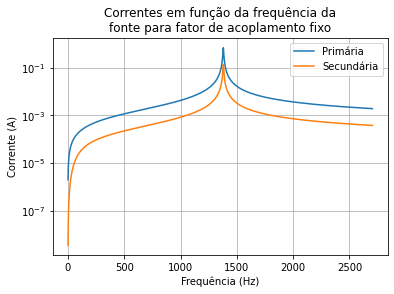

In [16]:
print('Corrente máxima na primária: %.3f A a %.1f Hz' % (round(abs(i1max), 3), round(fi1max, 1)))
print('Corrente máxima na secundária: %.3f A a %.1f Hz' % (round(abs(i2max), 3), round(fi2max, 1)))
print(f"Frequência de ressonância da etapa 1.1: {round(FREQUENCIA_RESONANTE, 1)} Hz")
        
plt.plot(freq, np.abs(correntes_primaria))
plt.plot(freq, np.abs(correntes_secundaria))
plt.yscale('log')
plt.grid(True)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Corrente (A)')
plt.title('Correntes em função da frequência da\nfonte para fator de acoplamento fixo')
plt.legend(['Primária', 'Secundária'])
plt.show()

In [8]:
correntes_primaria_k = []
correntes_secundaria_k = []
tensoes_carga_k = []

ks = np.linspace(0, 1, 1000)

for k in ks:
    resultados = calcular_transformador(uf, FREQUENCIA_RESONANTE, k)
    correntes_primaria_k.append(resultados['corrente-primaria'])
    correntes_secundaria_k.append(resultados['corrente-secundaria'])
    tensoes_carga_k.append(abs(resultados['tensao-carga']))

Frequência resonante: 1352 Hz


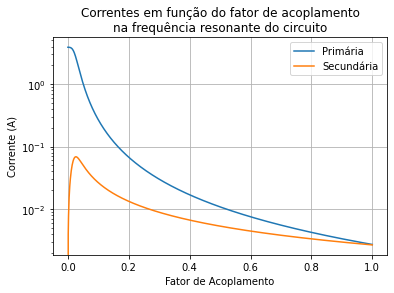

In [9]:
print('Frequência resonante: %d Hz' % round(FREQUENCIA_RESONANTE))
plt.plot(ks, np.abs(correntes_primaria_k))
plt.plot(ks, np.abs(correntes_secundaria_k))
plt.yscale('log')
plt.grid(True)
plt.xlabel('Fator de Acoplamento')
plt.ylabel('Corrente (A)')
plt.legend(['Primária', 'Secundária'])
plt.title('Correntes em função do fator de acoplamento\nna frequência resonante do circuito')
plt.show()

## Etapa 1.4

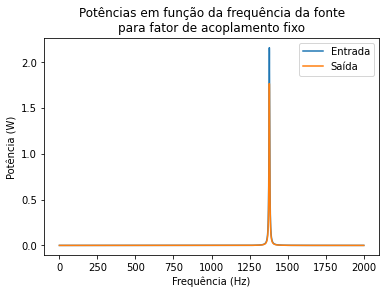

In [10]:
plt.plot(freq, potencias_entrada)
plt.plot(freq, potencias_saida)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Potência (W)')
plt.legend(['Entrada', 'Saída'])
plt.title('Potências em função da frequência da fonte\npara fator de acoplamento fixo')
plt.show()

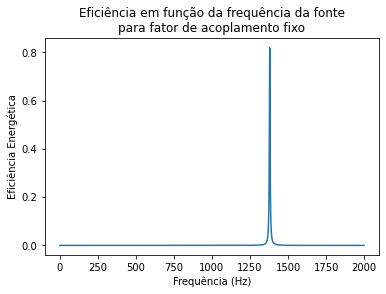

In [11]:
plt.plot(freq, eficiencias)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Eficiência Energética')
plt.title('Eficiência em função da frequência da fonte\npara fator de acoplamento fixo')
plt.show()

## Etapa 1.5

Frequência resonante: 1352 Hz


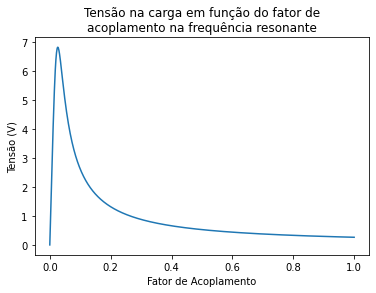

In [12]:
print('Frequência resonante: %d Hz' % round(FREQUENCIA_RESONANTE))
plt.plot(ks, tensoes_carga_k)
plt.xlabel('Fator de Acoplamento')
plt.ylabel('Tensão (V)')
plt.title('Tensão na carga em função do fator de\nacoplamento na frequência resonante')
plt.show()